In [92]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import io
import math 
import tensorflow as tf 
print(tf.__version__)
import math


2.2.0-rc4


In [93]:
uploaded = files.upload()

Saving WMT_data.csv to WMT_data (1).csv


In [0]:
walmart = pd.read_csv(io.BytesIO(uploaded['WMT_data.csv']))

In [95]:
walmart['close'].isnull().sum()

0

In [96]:
walmart

,date,open,high,low,close,volume,Name
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT
...,...,...,...,...,...,...,...
1254,2018-02-01,105.96,106.56,105.180,105.52,6386836,WMT
1255,2018-02-02,105.15,106.47,104.150,104.48,9253068,WMT
1256,2018-02-05,103.40,104.61,97.090,100.09,12561594,WMT
1257,2018-02-06,97.64,101.08,97.250,100.90,16413797,WMT


In [0]:
walmart['ret'] = walmart.close.pct_change(1).mul(100)

In [98]:
walmart.tail()

,date,open,high,low,close,volume,Name,ret
1254,2018-02-01,105.96,106.56,105.18,105.52,6386836,WMT,-1.013133
1255,2018-02-02,105.15,106.47,104.15,104.48,9253068,WMT,-0.985595
1256,2018-02-05,103.40,104.61,97.09,100.09,12561594,WMT,-4.201761
1257,2018-02-06,97.64,101.08,97.25,100.90,16413797,WMT,0.809272
1258,2018-02-07,100.50,104.59,100.01,102.85,11165223,WMT,1.932607


In [99]:
series = walmart['close']
print(series)
type(series)
time = np.arange(0,1259,1)
print(time)

0        71.48
1        71.40
2        71.40
3        71.39
4        70.82
         ...  
1254    105.52
1255    104.48
1256    100.09
1257    100.90
1258    102.85
Name: close, Length: 1259, dtype: float64
[   0    1    2 ... 1256 1257 1258]


In [14]:
##usinng returns instead of close price
series = walmart['ret']
print(series)
type(series)
time = np.arange(0,1259,1)
print(time)

0            NaN
1      -0.111919
2       0.000000
3      -0.014006
4      -0.798431
          ...   
1254   -1.013133
1255   -0.985595
1256   -4.201761
1257    0.809272
1258    1.932607
Name: ret, Length: 1259, dtype: float64
[   0    1    2 ... 1256 1257 1258]


In [0]:
series = series[1:]

In [0]:
##slicing time for uisng wih returns
time = np.arange(0,1258,1)

In [100]:
print(series.shape,time.shape)

(1259,) (1259,)


In [101]:
print(series)

0        71.48
1        71.40
2        71.40
3        71.39
4        70.82
         ...  
1254    105.52
1255    104.48
1256    100.09
1257    100.90
1258    102.85
Name: close, Length: 1259, dtype: float64


In [0]:
series = pd.Series.to_numpy(series)

In [103]:
series.shape

(1259,)

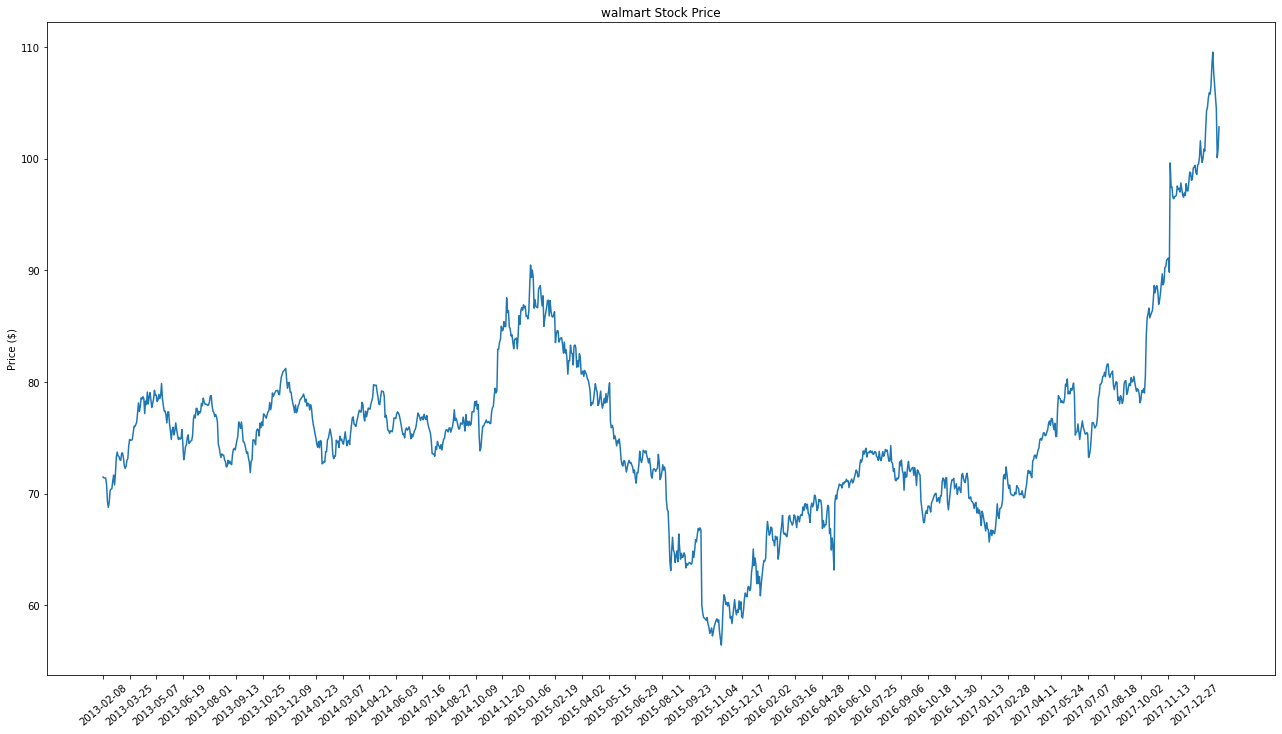

In [104]:
##plot the price
df = walmart.copy()
plt.figure(figsize = (22,12))
plt.plot(walmart.index, walmart['close'])
plt.title('walmart Stock Price')
plt.xticks(range(0,walmart.shape[0],30),walmart['date'].loc[::30],rotation=40)
plt.ylabel('Price ($)');
plt.show()


##PlotSeries function

##Split dataset

In [0]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 32
batch_size = 33
shuffle_buffer_size = 1000

In [107]:
series.shape

(1259,)

In [0]:
#create winidowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    #split the data into feature and lables 
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

##Model

In [111]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 32
batch_size = 32
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1100,)
Epoch 1/100
34/34 [==============================] - 1s 38ms/step - loss: 51.2346 - mse: 2759.6052 - lr: 1.0000e-08
Epoch 2/100
34/34 [==============================] - 1s 34ms/step - loss: 40.9127 - mse: 1790.3870 - lr: 1.1220e-08
Epoch 3/100
34/34 [==============================] - 1s 34ms/step - loss: 29.5158 - mse: 998.5530 - lr: 1.2589e-08
Epoch 4/100
34/34 [==============================] - 1s 34ms/step - loss: 17.0965 - mse: 464.6529 - lr: 1.4125e-08
Epoch 5/100
34/34 [==============================] - 1s 33ms/step - loss: 8.5876 - mse: 269.8535 - lr: 1.5849e-08
Epoch 6/100
34/34 [==============================] - 1s 32ms/step - loss: 8.0252 - mse: 257.6139 - lr: 1.7783e-08
Epoch 7/100
34/34 [==============================] - 1s 32ms/step - loss: 7.8750 - mse: 251.5814 - lr: 1.9953e-08
Epoch 8/100
34/34 [==============================] - 1s 34ms/step - loss: 7.7255 - mse: 244.95

##learning rate 

(1e-08, 0.0001, 0.0, 60.0)

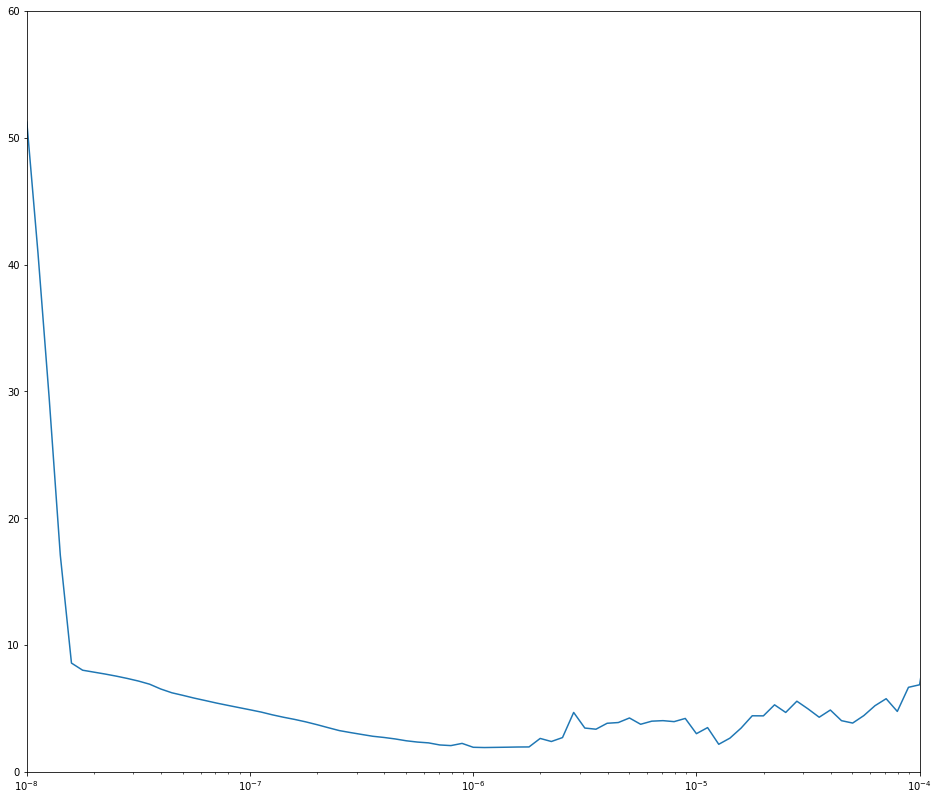

In [112]:
plt.figure(figsize=(16,14))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [113]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=32, batch_size=32, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_set,epochs=200)

Epoch 1/200
34/34 [==============================] - 1s 38ms/step - loss: 72.6266 - mse: 6926.6934
Epoch 2/200
34/34 [==============================] - 1s 36ms/step - loss: 10.2200 - mse: 210.9837
Epoch 3/200
34/34 [==============================] - 1s 36ms/step - loss: 5.5590 - mse: 69.6934
Epoch 4/200
34/34 [==============================] - 1s 36ms/step - loss: 4.2106 - mse: 38.1628
Epoch 5/200
34/34 [==============================] - 1s 36ms/step - loss: 3.9158 - mse: 32.8063
Epoch 6/200
34/34 [==============================] - 1s 35ms/step - loss: 3.5301 - mse: 27.5975
Epoch 7/200
34/34 [==============================] - 1s 34ms/step - loss: 3.3037 - mse: 24.5687
Epoch 8/200
34/34 [==============================] - 1s 34ms/step - loss: 3.2011 - mse: 22.9987
Epoch 9/200
34/34 [==============================] - 1s 34ms/step - loss: 3.0196 - mse: 20.9741
Epoch 10/200
34/34 [==============================] - 1s 34ms/step - loss: 2.8665 - mse: 19.1450
Epoch 11/200
34/34 [==============

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [115]:
tf.keras.metrics.mse(x_valid, rnn_forecast).numpy()

10.291982

In [116]:
RMSE = math.sqrt(tf.keras.metrics.mse(x_valid, rnn_forecast).numpy())
print('RMSE is equal to %.5f' %RMSE)

RMSE is equal to 3.20811


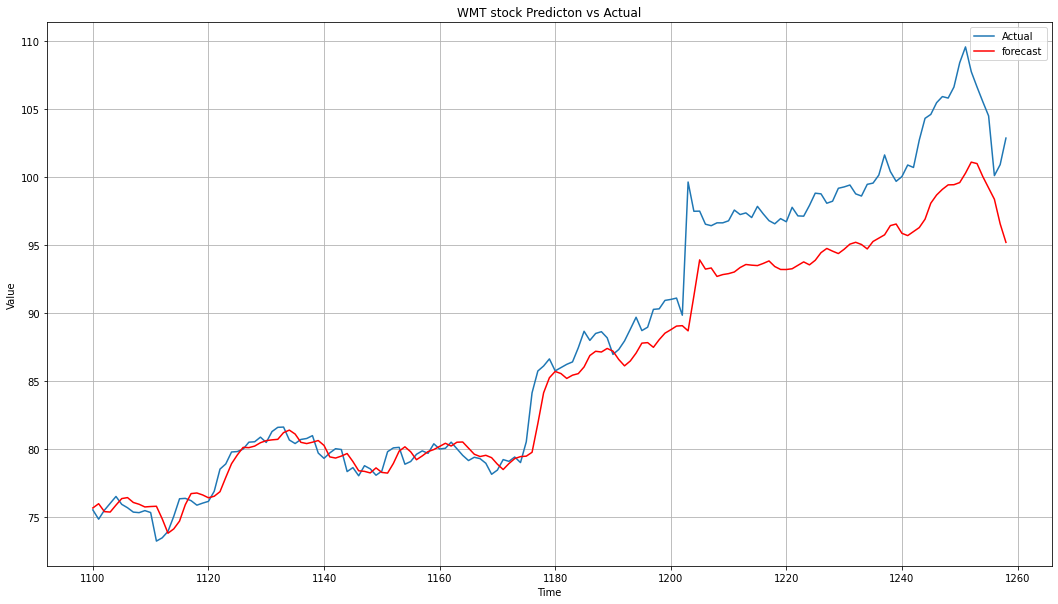

In [117]:
plt.figure(figsize=(18,10))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast,'#ff0000')
plt.title("WMT stock Predicton vs Actual")
plt.legend(["Actual","forecast"])


In [0]:
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

<Figure size 864x648 with 0 Axes>

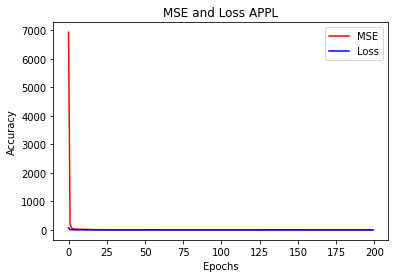

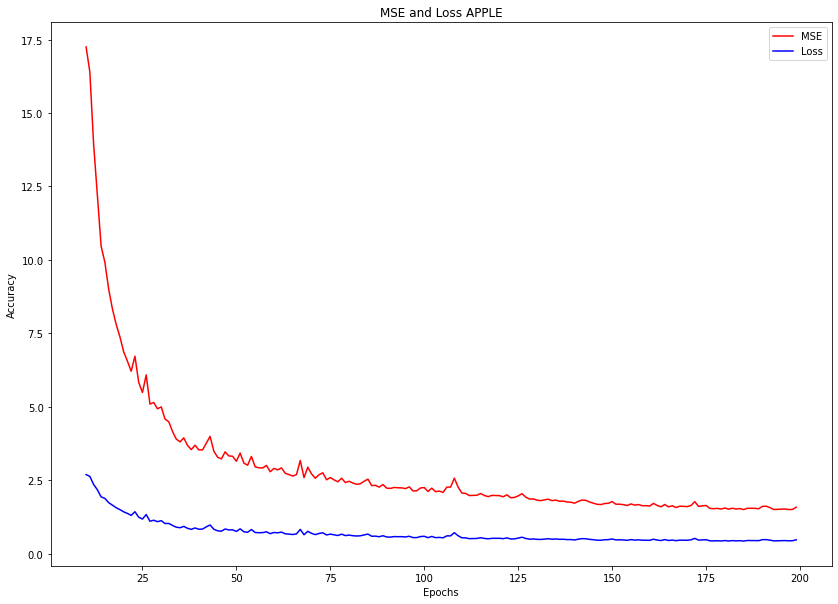

<Figure size 864x648 with 0 Axes>

In [119]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss APPL')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

epochs_zoom = epochs[10:]
mse_zoom = mse[10:]
loss_zoom = loss[10:]
plt.figure(figsize=(14,10))

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss APPLE')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])
plt.figure(figsize=(12,9))


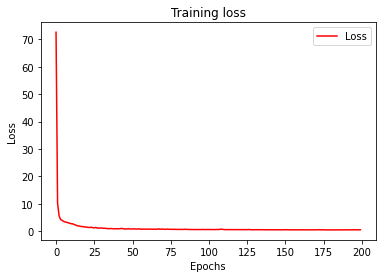

<Figure size 432x288 with 0 Axes>

In [120]:
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()
zoomed_loss = loss[50:]
zoomed_epochs = range(50,200)

In [121]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.2910643

<Figure size 432x288 with 0 Axes>

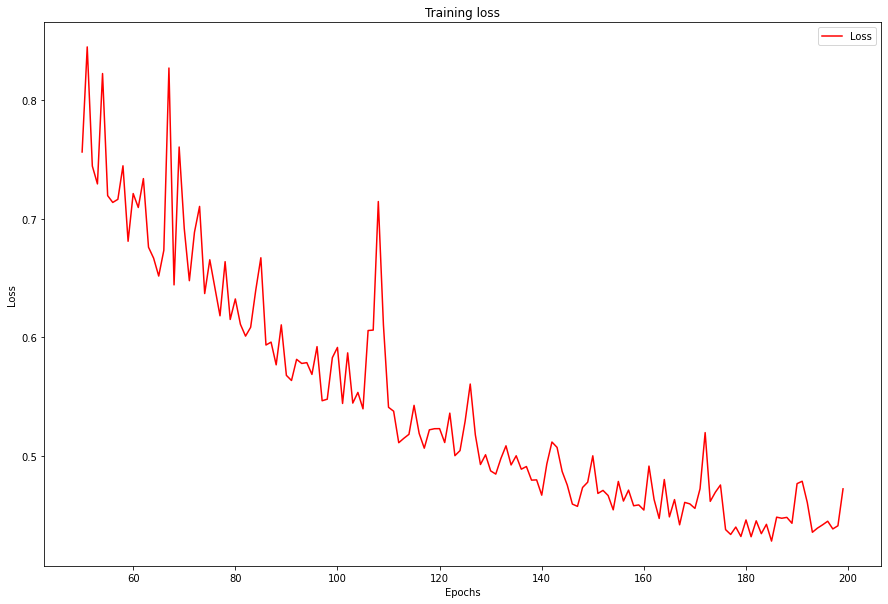

<Figure size 432x288 with 0 Axes>

In [122]:
plt.figure(figsize=(15,10))
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()